# Utils

In [ ]:
!pip install einops
!pip install wandb
import torch
import einops
import torch
from torch import nn

from einops import rearrange, repeat
from einops.layers.torch import Rearrange
import torchvision
import torchvision.transforms as transforms
import wandb


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.2/43.2 kB 624.8 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 7.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.3/207.3 kB 15.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 266.8/266.8 kB 16.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 6.9 MB/s eta 0:00:00


In [ ]:
import urllib.request
from pathlib import Path
import torch
import matplotlib.pyplot as plt
plt.rcParams["savefig.bbox"] = 'tight'

from torchvision.transforms import v2
from torchvision.io import read_image

torch.manual_seed(1)

import matplotlib.pyplot as plt
import torch
from torchvision.utils import draw_bounding_boxes, draw_segmentation_masks
from torchvision import tv_tensors
from torchvision.transforms.v2 import functional as F


def plot(imgs, row_title=None, **imshow_kwargs):
    if not isinstance(imgs[0], list):
        # Make a 2d grid even if there's just 1 row
        imgs = [imgs]

    num_rows = len(imgs)
    num_cols = len(imgs[0])
    _, axs = plt.subplots(nrows=num_rows, ncols=num_cols, squeeze=False)
    for row_idx, row in enumerate(imgs):
        for col_idx, img in enumerate(row):
            boxes = None
            masks = None
            if isinstance(img, tuple):
                img, target = img
                if isinstance(target, dict):
                    boxes = target.get("boxes")
                    masks = target.get("masks")
                elif isinstance(target, tv_tensors.BoundingBoxes):
                    boxes = target
                else:
                    raise ValueError(f"Unexpected target type: {type(target)}")
            img = F.to_image(img)
            if img.dtype.is_floating_point and img.min() < 0:
                # Poor man's re-normalization for the colors to be OK-ish. This
                # is useful for images coming out of Normalize()
                img -= img.min()
                img /= img.max()

            img = F.to_dtype(img, torch.uint8, scale=True)
            if boxes is not None:
                img = draw_bounding_boxes(img, boxes, colors="yellow", width=3)
            if masks is not None:
                img = draw_segmentation_masks(img, masks.to(torch.bool), colors=["green"] * masks.shape[0], alpha=.65)

            ax = axs[row_idx, col_idx]
            ax.imshow(img.permute(1, 2, 0).numpy(), **imshow_kwargs)
            ax.set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])

    if row_title is not None:
        for row_idx in range(num_rows):
            axs[row_idx, 0].set(ylabel=row_title[row_idx])

    plt.tight_layout()

# Dataset

In [ ]:
from google.colab import userdata
import os

os.environ["KAGGLE_KEY"] = userdata.get('KAGGLE_KEY')
os.environ["KAGGLE_USERNAME"] = userdata.get('KAGGLE_USERNAME')


In [ ]:
!kaggle datasets download -d praneshmukhopadhyay/youtubers-saying-things

! unzip "youtubers-saying-things.zip"


Dataset URL: https://www.kaggle.com/datasets/praneshmukhopadhyay/youtubers-saying-things
License(s): CC0-1.0
 82% 9.00M/11.0M [00:00<00:00, 39.7MB/s]
100% 11.0M/11.0M [00:00<00:00, 43.2MB/s]
Archive:  youtubers-saying-things.zip
  inflating: data.csv                


In [ ]:
!rm -rf images
!mkdir images

In [ ]:
from tqdm import tqdm
import csv
sample = None
from urllib.error import HTTPError


def path_to_img(path):
    img = read_image(path)
    plot([img])

def row_to_img(row, path):
    imgURL = f"https://i.ytimg.com/vi/{row[0]}/hqdefault.jpg"
    # print(imgURL)
    urllib.request.urlretrieve(imgURL, path)
    img = read_image(path)
    # transform = torchvision.transforms.CenterCrop(size=(224, 224))
    # out = transform(img)
    # return out
    return img
import sys
csv.field_size_limit(sys.maxsize)

def load():
  with open('data.csv', newline='') as f:
      reader = csv.reader(f)
      index = 0
      ids = []
      for row in tqdm(reader):
          index+=1
          if (index==1):
            continue
          sample =row
          dct = {}
          path = f"./images/{index}.jpg"
          try:
            row_to_img(row, path)
            dct['image'], dct['title'] = path, row[3]
            ids.append(dct)
          except HTTPError:
            print(f"No Id for {index}")
            index-=1

          if (index>2500):
            break
  return ids

In [ ]:
ids = load()

333it [00:12, 31.33it/s]

No Id for 331


1943it [00:54, 49.25it/s]

No Id for 1936


2502it [01:05, 38.03it/s]


'Interview with a Competitive Programmer'

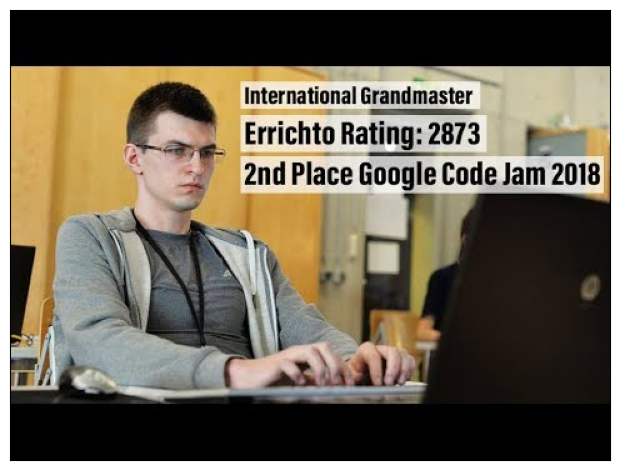

In [ ]:
idx = -1
path_to_img(ids[idx]['image'])
ids[idx]['title']

In [ ]:
titles = [section['title'] for section in ids]
paths = [section['image'] for section in ids]


In [ ]:
from transformers import DistilBertModel, DistilBertConfig, DistilBertTokenizer

tokenizer = DistilBertTokenizer.from_pretrained("distilbert-base-uncased")
class CLIPDataset(torch.utils.data.Dataset):
  def __init__(self, titles, paths, tokenizer=tokenizer, transform=torchvision.transforms.CenterCrop(size=(80, 80))):
    super().__init__()
    self.titles = titles
    self.paths = paths
    assert len(self.titles) == len(self.paths), "Mis-matched lengths"

    self.tokenizer = tokenizer
    self.transform = transform

    # self.captions = list(captions)
    self.encoded_captions = tokenizer(
        list(titles), padding=True, truncation=True, max_length=100
    )

  def __len__(self):
    return len(self.titles)

  # def __getitem__(self, idx):
  #   title, path = self.titles[idx], self.paths[idx]
  #   img = self.transform(read_image(path))
  #   tokens = self.tokenizer(
  #           list(title), padding=True, truncation=True, max_length=30
  #   )

  #   # return img, 0
  #   return img, [tokens]
  def __getitem__(self, idx):
    title, path = self.titles[idx], self.paths[idx]
    img = self.transform(read_image(path))

    item = {
        key: torch.tensor(values[idx])
        for key, values in self.encoded_captions.items()
    }

    item['image']=img





    return item




/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

In [ ]:
dataset = CLIPDataset(titles,paths)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=32, shuffle=True)

In [ ]:
iteration = iter(dataloader)
ne = next(iteration)


In [ ]:
ne = None
for batch in iteration:
  ne = batch
  break



# Architectures


In [ ]:
def pair(t):
    return t if isinstance(t, tuple) else (t, t)

class Attention(nn.Module):
    def __init__(self, dim, heads, dim_head):
        super().__init__()
        inner_dim = dim_head *  heads
        self.heads = heads
        self.scale = dim_head ** -0.5
        self.norm = nn.LayerNorm(dim)

        self.attend = nn.Softmax(dim = -1)

        self.to_qkv = nn.Linear(dim, inner_dim * 3, bias = False)
        self.to_out = nn.Linear(inner_dim, dim, bias = False)

    def forward(self,input):
        x = self.norm(input)
        qkv = self.to_qkv(x).chunk(3,dim=-1)
        q, k, v = map(lambda t: rearrange(t, 'b n (h d) -> b h n d', h = self.heads), qkv)

        dots = torch.matmul(q, k.transpose(-1, -2)) * self.scale

        attn = self.attend(dots)

        out = torch.matmul(attn, v)
        out = rearrange(out, 'b h n d -> b n (h d)')

        return self.to_out(out)

class FeedForward(nn.Module):
  def __init__(self,dim, hidden_dim):
    super().__init__()
    self.network = nn.Sequential(
        nn.LayerNorm(dim),
        nn.Linear(dim, hidden_dim),
        nn.GELU(),
        nn.Linear(hidden_dim, dim)
    )
  def forward(self, input):
    return self.network(input)

class Transformer(nn.Module):
    def __init__(self, dim, depth, heads, dim_head, mlp_dim):
        super().__init__()
        self.norm = nn.LayerNorm(dim)
        self.layers = nn.ModuleList([])
        for _ in range(depth):
            self.layers.append(nn.ModuleList([
                Attention(dim, heads, dim_head),
                FeedForward(dim, mlp_dim)
            ]))

    def forward(self, x):
      for (attn, ff) in self.layers:
        x = attn(x) + x
        x = ff(x) + x
      return self.norm(x)



class ViT(nn.Module):
    def __init__(self, *, image_size, patch_size, num_classes, dim, depth, heads, mlp_dim, pool = 'cls', channels = 3, dim_head = 64, dropout = 0., emb_dropout = 0.):
        super().__init__()
        image_height, image_width = pair(image_size)
        patch_height, patch_width = pair(patch_size)

        assert image_height % patch_height == 0 and image_width % patch_width == 0, 'Image dimensions must be divisible by the patch size.'

        num_patches = (image_height // patch_height) * (image_width // patch_width)
        patch_dim = channels * patch_height * patch_width
        assert pool in {'cls', 'mean'}, 'pool type must be either cls (cls token) or mean (mean pooling)'

        self.to_patch_embedding = nn.Sequential(
            Rearrange('b c (h p1) (w p2) -> b (h w) (p1 p2 c)', p1 = patch_height, p2 = patch_width),
            nn.LayerNorm(patch_dim),
            nn.Linear(patch_dim, dim),
            nn.LayerNorm(dim),
        )

        self.pos_embedding = nn.Parameter(torch.randn(1, num_patches + 1, dim))
        self.cls_token = nn.Parameter(torch.randn(1, 1, dim))
        self.dropout = nn.Dropout(emb_dropout)

        self.transformer = Transformer(dim, depth, heads, dim_head, mlp_dim)

        self.pool = pool
        self.to_latent = nn.Identity()

        self.mlp_head = nn.Linear(dim, num_classes)

    def forward(self, img):
        x = self.to_patch_embedding(img)
        b, n, _ = x.shape

        cls_tokens = repeat(self.cls_token, '1 1 d -> b 1 d', b = b)
        x = torch.cat((cls_tokens, x), dim=1)
        x += self.pos_embedding[:, :(n + 1)]
        x = self.dropout(x)

        x = self.transformer(x)

        x = x.mean(dim = 1) if self.pool == 'mean' else x[:, 0]

        x = self.to_latent(x)
        return self.mlp_head(x)



In [ ]:
class TextEncoder(nn.Module):

    def __init__(self, model_name="distilbert-base-uncased", pretrained=True, trainable=True):
        super().__init__()
        if pretrained:
            self.model = DistilBertModel.from_pretrained(model_name)
        else:
            self.model = DistilBertModel(config=DistilBertConfig())

        for p in self.model.parameters():
            p.requires_grad = trainable

        # we are using the CLS token hidden representation as the sentence's embedding
        self.target_token_idx = 0

    def forward(self, input_ids, attention_mask):
        output = self.model(input_ids=input_ids, attention_mask=attention_mask)
        last_hidden_state = output.last_hidden_state
        return last_hidden_state[:, self.target_token_idx, :]


In [ ]:
class Projection(nn.Module):
    def __init__(self, in_dim, out_dim, dropout=.1):
        super().__init__()
        self.in_to_out = nn.Linear(in_dim, out_features=out_dim)
        self.fc = nn.Sequential(
            nn.GELU(),
            nn.Linear(out_dim, out_dim),
            nn.Dropout(dropout)
        )
        self.layer_norm = nn.LayerNorm(out_dim)


    def forward(self, input):
      input = self.in_to_out(input)
      x = self.fc(input) + input
      return self.layer_norm(x)

In [ ]:
from torch.nn.functional import softmax

class CLIP(nn.Module):


  def __init__(self):
    super().__init__()
    self.text_encoder = TextEncoder()
    self.image_encoder = ViT(
      channels=3,
      image_size=80,
      patch_size=8,
      num_classes=256,
      dim=64,
      depth=6,
      heads=8,
      mlp_dim=128,
      dropout=0.1,
      emb_dropout=0.1
    )
    self.temperature = 1.0

    self.text_projection = Projection(768, 200)
    self.vision_projection = Projection(256, 200)


  def forward(self, ids, attn, c):

    text_embedding = self.text_encoder(ids, attn)
    vision_embedding = self.image_encoder(c)
    text_multi = self.text_projection(text_embedding)
    vision_multi = self.vision_projection(vision_embedding)

    logits = (text_multi @ vision_multi.T) / self.temperature

    images_similarity = vision_multi @ vision_multi.T
    texts_similarity = text_multi @ text_multi.T

    targets = softmax(
        (images_similarity + texts_similarity) / 2 * self.temperature, dim=-1
    )

    texts_loss = cross_entropy(logits, targets, reduction='none')
    images_loss = cross_entropy(logits.T, targets.T, reduction='none')
    loss =  (images_loss + texts_loss) / 2.0 # shape: (batch_size)
    return loss.mean()

def cross_entropy(preds, targets, reduction='none'):
    log_softmax = nn.LogSoftmax(dim=-1)
    loss = (-targets * log_softmax(preds)).sum(1)
    if reduction == "none":
        return loss
    elif reduction == "mean":
        return loss.mean()


In [ ]:
clip_model = CLIP()


model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

In [ ]:
# testing
iteration = iter(dataloader)
next = next(iteration)
c = next['image'].to(dtype=torch.float32)
ids = next['input_ids']
attn = next['attention_mask']
out = clip_model(ids, attn, c)

In [ ]:
out

tensor(12.4106, grad_fn=<MeanBackward0>)

# Training

In [ ]:
import torch
import wandb
from torch.nn.functional import softmax
from torch.utils.data import DataLoader
from tqdm import tqdm

# Initialize wandb
wandb.init(project="CLIP")

# Define CLIP model
clip_model = CLIP()

# Define your optimizer
optimizer = torch.optim.Adam(clip_model.parameters(), lr=1e-4)

# Define your data loader
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)



Loss,█▇▆▅▅▅▆▄▄▄▃▄▃▃▃▂▂▂▂▂▂▁▂▁▂▂▁▂▁▁▁▂▂▁▁▁▁▁▁▁
Loss,4.18955


Problem at: <ipython-input-32-e658797a9bc3> 8 <cell line: 8>


KeyboardInterrupt: 

In [ ]:

# Training loop
num_epochs = 1
for epoch in range(num_epochs):
    clip_model.train()
    total_loss = 0.0

    for batch in tqdm(dataloader, desc=f"Epoch {epoch+1}/{num_epochs}"):
        optimizer.zero_grad()

        # Extract data from batch
        c = batch['image'].to(dtype=torch.float32)
        ids = batch['input_ids']
        attn = batch['attention_mask']

        # Forward pass
        loss = clip_model(ids, attn, c)

        # Backward pass
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        wandb.log({"Loss": loss.item()})
        print(loss.item())

    # Calculate average loss for the epoch
    avg_loss = total_loss / len(dataloader)

    # Log the loss to wandb
    # wandb.log({" Loss": avg_loss})


Epoch 1/1:   1%|▏         | 1/79 [00:08<10:52,  8.37s/it]

11.237615585327148


Epoch 1/1:   3%|▎         | 2/79 [00:14<08:47,  6.85s/it]

10.5931396484375


Epoch 1/1:   4%|▍         | 3/79 [00:20<08:35,  6.79s/it]

9.211712837219238


Epoch 1/1:   5%|▌         | 4/79 [00:26<07:40,  6.14s/it]

8.91296100616455


Epoch 1/1:   6%|▋         | 5/79 [00:33<07:58,  6.47s/it]

8.136175155639648


Epoch 1/1:   8%|▊         | 6/79 [00:40<08:14,  6.78s/it]

8.231929779052734


Epoch 1/1:   9%|▉         | 7/79 [00:48<08:45,  7.30s/it]

7.739376068115234


Epoch 1/1:  10%|█         | 8/79 [00:54<08:11,  6.93s/it]

9.967597961425781


Epoch 1/1:  11%|█▏        | 9/79 [01:00<07:35,  6.50s/it]

8.835023880004883


Epoch 1/1:  13%|█▎        | 10/79 [01:06<07:22,  6.41s/it]

7.579631328582764


Epoch 1/1:  14%|█▍        | 11/79 [01:11<06:49,  6.02s/it]

7.006594657897949


Epoch 1/1:  15%|█▌        | 12/79 [01:18<06:53,  6.18s/it]

6.524137020111084


Epoch 1/1:  16%|█▋        | 13/79 [01:23<06:30,  5.92s/it]

7.138975143432617


Epoch 1/1:  18%|█▊        | 14/79 [01:30<06:32,  6.04s/it]

5.910055160522461


Epoch 1/1:  19%|█▉        | 15/79 [01:36<06:26,  6.04s/it]

7.115748405456543


Epoch 1/1:  20%|██        | 16/79 [01:47<07:57,  7.58s/it]

5.462704658508301


Epoch 1/1:  22%|██▏       | 17/79 [01:58<09:03,  8.76s/it]

6.644552230834961


Epoch 1/1:  23%|██▎       | 18/79 [02:05<08:23,  8.26s/it]

6.438596248626709


Epoch 1/1:  24%|██▍       | 19/79 [02:11<07:27,  7.46s/it]

5.876593589782715


Epoch 1/1:  25%|██▌       | 20/79 [02:17<06:56,  7.05s/it]

5.955972194671631


Epoch 1/1:  27%|██▋       | 21/79 [02:22<06:15,  6.47s/it]

5.607110500335693


Epoch 1/1:  28%|██▊       | 22/79 [02:29<06:08,  6.46s/it]

5.220779895782471


Epoch 1/1:  29%|██▉       | 23/79 [02:34<05:38,  6.04s/it]

5.325167179107666


Epoch 1/1:  30%|███       | 24/79 [02:40<05:34,  6.07s/it]

5.109144687652588


Epoch 1/1:  32%|███▏      | 25/79 [02:45<05:19,  5.91s/it]

5.452844142913818


Epoch 1/1:  33%|███▎      | 26/79 [02:51<05:02,  5.70s/it]

5.11401891708374


Epoch 1/1:  34%|███▍      | 27/79 [03:00<05:53,  6.81s/it]

4.76624059677124


Epoch 1/1:  35%|███▌      | 28/79 [03:13<07:22,  8.69s/it]

4.898575782775879


Epoch 1/1:  37%|███▋      | 29/79 [03:28<08:49, 10.59s/it]

4.6130571365356445


Epoch 1/1:  38%|███▊      | 30/79 [03:39<08:50, 10.82s/it]

4.970892906188965


Epoch 1/1:  39%|███▉      | 31/79 [03:49<08:22, 10.46s/it]

4.624349117279053


Epoch 1/1:  41%|████      | 32/79 [04:01<08:35, 10.97s/it]

4.5176873207092285


Epoch 1/1:  42%|████▏     | 33/79 [04:09<07:42, 10.06s/it]

4.6960248947143555


Epoch 1/1:  43%|████▎     | 34/79 [04:20<07:38, 10.19s/it]

4.852628707885742


Epoch 1/1:  44%|████▍     | 35/79 [04:32<07:54, 10.77s/it]

4.626138210296631


Epoch 1/1:  46%|████▌     | 36/79 [04:45<08:19, 11.63s/it]

4.596419334411621


Epoch 1/1:  47%|████▋     | 37/79 [04:56<07:56, 11.36s/it]

4.6930389404296875


Epoch 1/1:  48%|████▊     | 38/79 [05:08<07:50, 11.48s/it]

4.662289142608643


Epoch 1/1:  49%|████▉     | 39/79 [05:17<07:14, 10.86s/it]

4.449874401092529


Epoch 1/1:  51%|█████     | 40/79 [05:28<06:59, 10.74s/it]

4.407107830047607


Epoch 1/1:  52%|█████▏    | 41/79 [05:39<06:57, 10.98s/it]

4.562349319458008


Epoch 1/1:  53%|█████▎    | 42/79 [05:44<05:41,  9.23s/it]

4.2036333084106445


Epoch 1/1:  54%|█████▍    | 43/79 [05:51<05:02,  8.42s/it]

4.708804607391357


Epoch 1/1:  56%|█████▌    | 44/79 [05:56<04:19,  7.43s/it]

4.753394603729248


Epoch 1/1:  57%|█████▋    | 45/79 [06:02<04:02,  7.13s/it]

4.28397798538208


Epoch 1/1:  58%|█████▊    | 46/79 [06:08<03:35,  6.53s/it]

5.0924296379089355


Epoch 1/1:  59%|█████▉    | 47/79 [06:13<03:15,  6.11s/it]

4.142763137817383


Epoch 1/1:  61%|██████    | 48/79 [06:19<03:12,  6.20s/it]

4.594529628753662


Epoch 1/1:  62%|██████▏   | 49/79 [06:24<02:55,  5.86s/it]

4.187466621398926


Epoch 1/1:  63%|██████▎   | 50/79 [06:32<03:08,  6.49s/it]

4.758054256439209


Epoch 1/1:  65%|██████▍   | 51/79 [06:37<02:50,  6.08s/it]

4.176065444946289


Epoch 1/1:  66%|██████▌   | 52/79 [06:43<02:40,  5.94s/it]

4.44538688659668


Epoch 1/1:  67%|██████▋   | 53/79 [06:49<02:34,  5.93s/it]

4.48857307434082


Epoch 1/1:  68%|██████▊   | 54/79 [06:54<02:22,  5.68s/it]

4.189548969268799


Epoch 1/1:  68%|██████▊   | 54/79 [07:00<03:14,  7.79s/it]


KeyboardInterrupt: 

# Evaluating Trained Model with embeddings

In [ ]:
text_encoder =    clip_model.text_encoder
image_encoder =    clip_model.image_encoder


text_projection=    clip_model.text_projection
vision_projection =  clip_model.vision_projection


In [ ]:
ne = None
for batch in iteration:
  ne = batch
  break


c = ne['image'].to(dtype=torch.float32)
ids = ne['input_ids']
attn = ne['attention_mask']


In [ ]:
text_embedding = text_encoder(ids, attn)
vision_embedding = image_encoder(c)


In [ ]:
text_multi = text_projection(text_embedding)
vision_multi = vision_projection(vision_embedding)


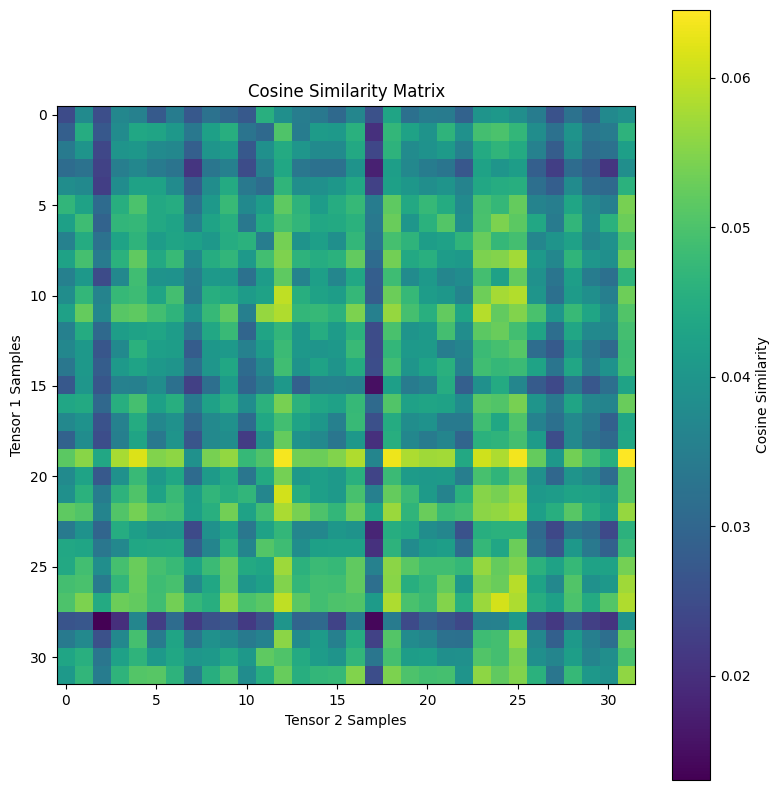

In [ ]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt



# Compute the cosine similarity matrix
similarity_matrix = F.cosine_similarity(vision_multi.unsqueeze(1), text_multi.unsqueeze(0), dim=2)

# Plot the similarity matrix
plt.figure(figsize=(8, 8))
plt.imshow(similarity_matrix.detach().numpy(), cmap='viridis')
plt.colorbar(label='Cosine Similarity')
plt.xlabel('Tensor 2 Samples')
plt.ylabel('Tensor 1 Samples')
plt.title('Cosine Similarity Matrix')
plt.tight_layout()
plt.show()

In [ ]:
ids.shape

In [ ]:
output = model(c)